In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time

Pickling Data

In [2]:
# df.to_pickle('df {}'.format(str(datetime.datetime.today())))

Import data from my machine

In [38]:
#df = pd.read_csv('2018_mta_data.csv')
df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_181229.txt') 

Clean messy columns

In [39]:
#df.drop('EXITS',axis=1,inplace=True)
#df.drop('Unnamed: 0',axis=1,inplace=True)

In [40]:
df.rename(columns={'EXITS                                                               ': 'EXITS'},inplace=True)
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

Remove random entries (e.g. entry at 11:22:57)

Create datetime object for sorting

In [41]:
df['DATE_TIME'] = df['DATE'] + ' ' + df['TIME']

In [42]:
%%time
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

CPU times: user 16.7 s, sys: 22.4 ms, total: 16.8 s
Wall time: 16.2 s


Remove random entries

In [43]:
df = df[(df['DATE_TIME'].dt.second == 0) & (df['DATE_TIME'].dt.minute == 0)]

Create differences column

In [44]:
df[['ENTRIES','EXITS']] = df[['ENTRIES','EXITS']].diff()

Sum differences columns based on date, time, and station. Includes linename for later use.

In [45]:
df = df.groupby(['STATION','DATE_TIME','LINENAME']).sum()

Adds the groupby indices back into the df as columns

In [46]:
df.reset_index(inplace=True)

### Imputing values

##### Create shifted columns for entries and exits

Sort on station and datetime for diff calculating

In [47]:
df.sort_values(['STATION','DATE_TIME'],inplace=True)

Adds day of week column to confirm alignment

In [48]:
df['DOW'] = df['DATE_TIME'].dt.day_name()

In [49]:
df.reset_index(drop=True,inplace=True)

Creates shift of one week for imputation

In [70]:
df['PRE_DAY_ENTRY'] = df.ENTRIES.shift(42)
df['PRE_DAY_EXIT'] = df.EXITS.shift(42)

##### Making outliers NaN

Find standard deviations for entries and exits  
Remove negative and extremely high values

In [51]:
entries_std = np.std(df[(df['ENTRIES']<250000) & (df['ENTRIES']>0)]['ENTRIES'])
entries_std # 7384.575825127392

5473.612432609019

In [52]:
exits_std = np.std(df[(df['EXITS']<250000) & (df['EXITS']>0)]['EXITS'])
exits_std # 7485.692691378577

5526.416640811191

Set appropriate values to NaN

Convert float to int in entries and exits columns

In [55]:
df.dropna(inplace=True)

In [19]:
# df[['ENTRIES','EXITS']] = pd.DataFrame.astype(df[['ENTRIES','EXITS']],int)

_Not sure why but I've been needing to run these cells several times for things to work..._

In [68]:
df.loc[df['ENTRIES'] > entries_std*2, 'ENTRIES'] = np.nan
df.loc[df['ENTRIES'] < 0, 'ENTRIES'] = np.nan

df.loc[df['EXITS'] > entries_std*2, 'EXITS'] = np.nan
df.loc[df['EXITS'] < 0, 'EXITS'] = np.nan

Replace nan with corresponding value from respective PRE_DAY column

In [71]:
df['ENTRIES'].fillna(df['PRE_DAY_ENTRY'],inplace=True)
df['EXITS'].fillna(df['PRE_DAY_EXIT'],inplace=True)

# IN THE FUTURE FIND REMAINING NANS AND REPLACE WITH MEDIAN

Remove remaining NaN

Remove old PRE_DAY columns

In [59]:
df.drop(['PRE_DAY_ENTRY','PRE_DAY_EXIT'],inplace=True,axis=1)

## Create new useful columns

In [60]:
df['DAY_NUM'] = df['DATE_TIME'].dt.dayofweek
df['HOUR'] = df['DATE_TIME'].dt.hour
df['MONTH'] = df['DATE_TIME'].dt.month
df['QUARTER'] = df['DATE_TIME'].dt.quarter

## Visualizations

In [72]:
weeklydf = df.groupby(['STATION','DOW','DAY_NUM','HOUR']).mean()

In [73]:
weeklydf.reset_index(inplace=True)

In [74]:
# top_weeklydf.sort_values(['STATION','DAY_NUM','HOUR'],inplace=True)

In [75]:
weeklydf['DAY_HOUR'] = weeklydf['DOW'] + ' ' + weeklydf['HOUR'].apply(str)

In [76]:
top_stations = list(weeklydf.groupby('STATION').sum()['ENTRIES'].nlargest(10).index)

In [77]:
top_weeklydf = weeklydf[weeklydf['STATION'].isin(top_stations)]

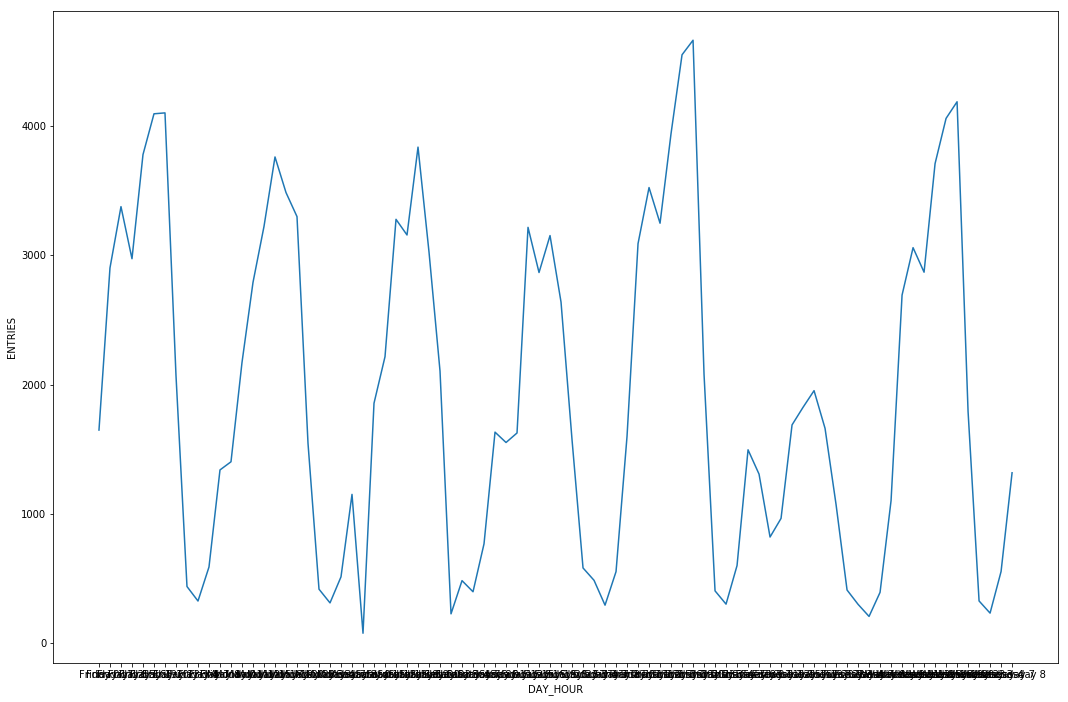

In [78]:
plt.figure(figsize=(18,12))
sns.lineplot(data=weeklydf[weeklydf['STATION']=='125 ST'],x='DAY_HOUR',y='ENTRIES')

In [80]:
test = df[df['STATION']=='34 ST-PENN STA']

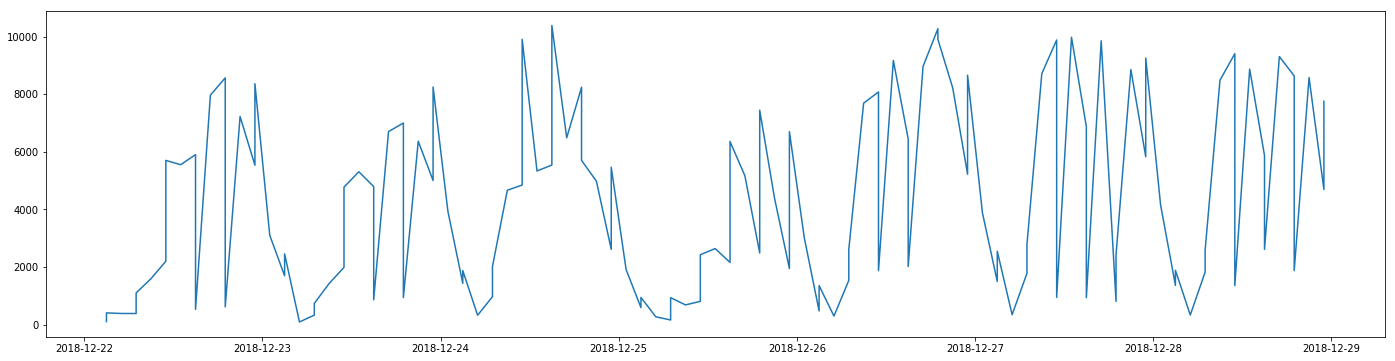

In [81]:
plt.figure(figsize=(24,6))
plt.plot(test['DATE_TIME'],test['ENTRIES'])

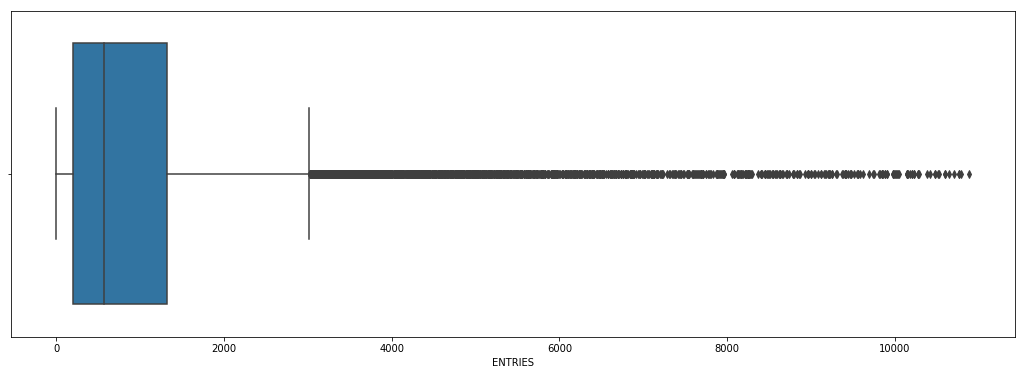

In [84]:
plt.figure(figsize=(18,6))
sns.boxplot(df['ENTRIES'])